> You can download dataset here: http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes (Corrected indian pines)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/University/GIS/

/content/drive/MyDrive/University/GIS


In [2]:
!pip install earthpy

     |████████████████████████████████| 1.4 MB 11.5 MB/s 
     |████████████████████████████████| 19.3 MB 2.0 MB/s 
     |████████████████████████████████| 1.0 MB 32.1 MB/s 
     |████████████████████████████████| 15.4 MB 128 kB/s 
     |████████████████████████████████| 6.3 MB 7.6 MB/s 


In [3]:
import numpy as np
from numpy.random import seed, randint
seed(11)

from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import earthpy.plot as earth_plt

import tensorflow
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten, Conv2D

from time import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.models import load_model

import plotly.graph_objects as go
from seaborn import heatmap

In [ ]:
data = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
# ground truth
gt = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
print('Data Shape:', data.shape[:-1], '\nNumber of Bands:', data.shape[-1])

Data Shape: (145, 145) 
Number of Bands: 200


In [ ]:
bands_num = 200
df = pd.DataFrame(data.reshape(data.shape[0] * data.shape[1], bands_num))
df.columns = [f'band {i}' for i in range(1, bands_num + 1)]
df['class'] = gt.ravel()

df.head()

,band 1,band 2,band 3,band 4,band 5,band 6,band 7,band 8,band 9,band 10,band 11,band 12,band 13,band 14,band 15,band 16,band 17,band 18,band 19,band 20,band 21,band 22,band 23,band 24,band 25,band 26,band 27,band 28,band 29,band 30,band 31,band 32,band 33,band 34,band 35,band 36,band 37,band 38,band 39,band 40,...,band 162,band 163,band 164,band 165,band 166,band 167,band 168,band 169,band 170,band 171,band 172,band 173,band 174,band 175,band 176,band 177,band 178,band 179,band 180,band 181,band 182,band 183,band 184,band 185,band 186,band 187,band 188,band 189,band 190,band 191,band 192,band 193,band 194,band 195,band 196,band 197,band 198,band 199,band 200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,4816,4769,4610,4805,4828,4861,4767,4624,4549,4463,4462,4446,4445,4336,4381,4319,4207,4305,4311,3991,4168,3942,4061,4362,4318,4252,4869,5284,5055,3591,...,1396,1381,1396,1381,1353,1346,1341,1332,1324,1310,1318,1330,1310,1292,1280,1275,1266,1264,1233,1241,1232,1215,1215,1187,1168,1171,1150,1134,1123,1135,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,5141,5100,4994,5172,5290,5289,5217,5053,5033,4939,4931,4941,4902,4824,4859,4805,4698,4794,4806,4452,4628,4433,4643,4967,4853,4760,5449,5768,5684,3987,...,1421,1415,1428,1415,1379,1370,1360,1353,1352,1336,1346,1351,1330,1315,1305,1292,1282,1286,1259,1259,1250,1229,1232,1195,1177,1184,1153,1137,1138,1137,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,5227,5172,5097,5313,5411,5412,5341,5191,5140,5069,5110,5119,5046,4981,5023,4987,4862,4965,4992,4595,4756,4529,4801,5077,4983,4868,5515,5972,5913,4027,...,1446,1440,1443,1425,1390,1379,1376,1363,1355,1347,1361,1356,1341,1330,1321,1304,1290,1289,1263,1269,1261,1245,1241,1214,1185,1188,1156,1147,1149,1144,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,5147,5078,5040,5237,5321,5344,5255,5121,5035,4956,4994,4980,4905,4857,4900,4831,4720,4848,4847,4484,4613,4402,4674,4966,4848,4776,5473,5894,5789,4086,...,1432,1427,1426,1416,1386,1374,1375,1359,1343,1343,1354,1351,1333,1329,1313,1296,1280,1281,1251,1255,1253,1238,1223,1207,1188,1188,1154,1143,1144,1146,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,4853,4857,4734,4879,4976,4958,4885,4754,4647,4532,4586,4591,4492,4453,4497,4398,4297,4408,4401,4102,4227,4075,4264,4529,4490,4438,5001,5378,5321,3779,...,1401,1397,1395,1390,1368,1349,1354,1340,1330,1324,1336,1332,1320,1307,1287,1283,1267,1265,1239,1240,1239,1229,1212,1202,1178,1178,1143,1135,1138,1135,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


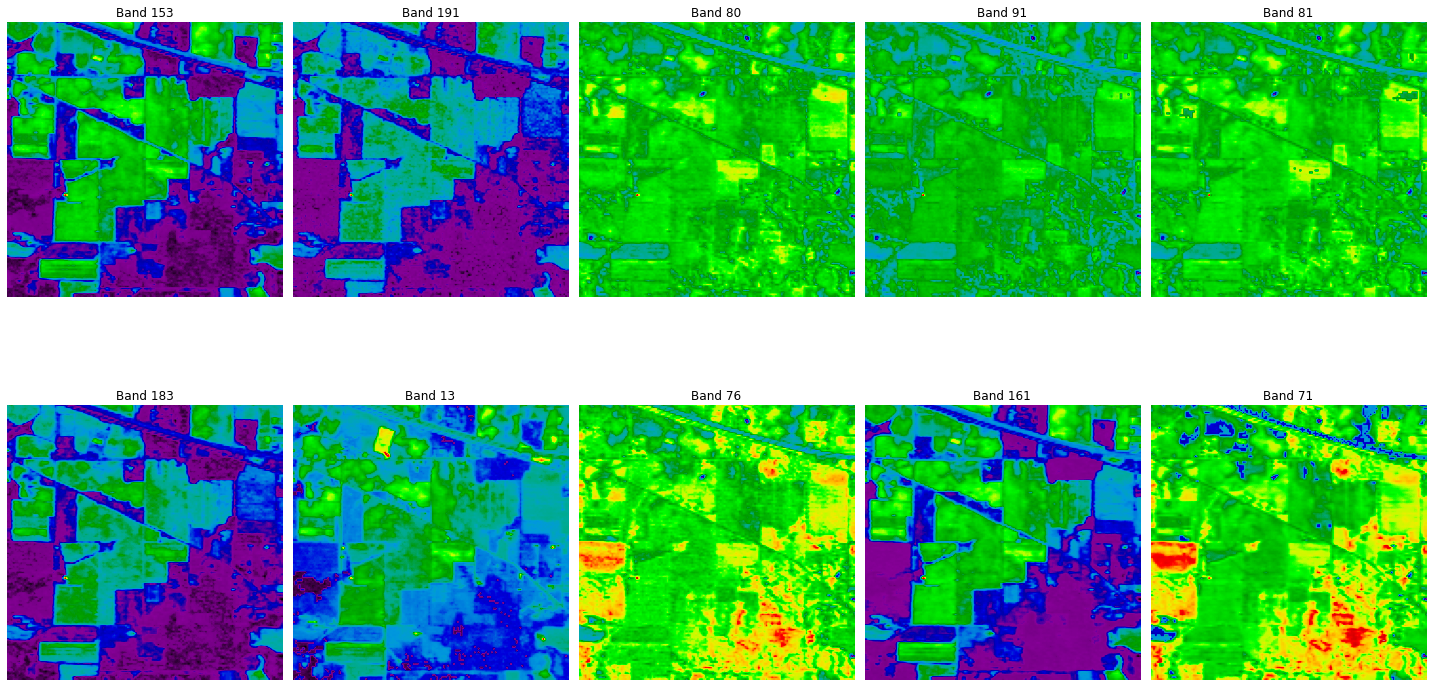

In [ ]:
fig = plt.figure(figsize = (20, 12))
ax = fig.subplots(2, 5)

for r in range(2):
  for c in range(5):    
    i = randint(bands_num)
    ax[r][c].imshow(data[:, :, i], cmap = 'nipy_spectral')
    ax[r][c].axis('off')
    ax[r][c].title.set_text(f"Band {i}")

plt.tight_layout()
plt.show()

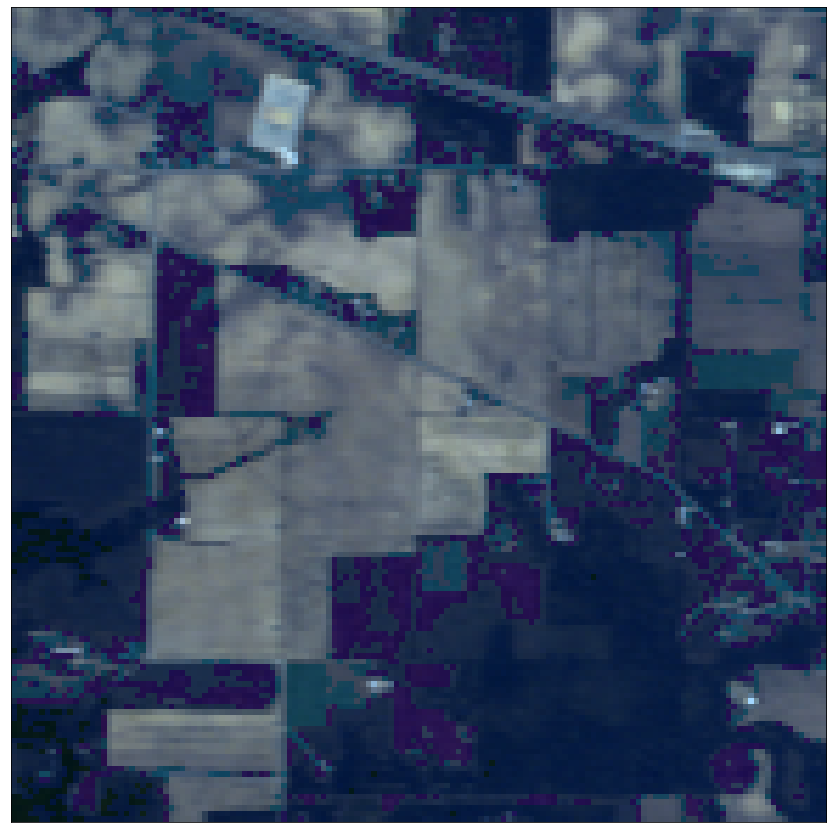

In [ ]:
earth_plt.plot_rgb(np.moveaxis(data, 2, 0), rgb = (30, 20, 10), figsize = (15, 15)) 
plt.show()

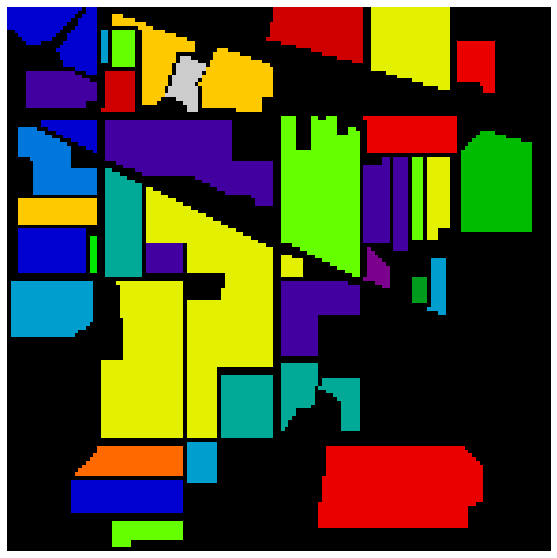

In [ ]:
fig = plt.figure(figsize = (12, 10))
plt.imshow(gt, cmap = 'nipy_spectral')
plt.axis('off')
plt.show()

In [ ]:
t_df = df[df['class'] != 0]
X_scaled = minmax_scale(t_df.drop(columns = ['class']))
y = to_categorical(t_df.loc[:, 'class'])[:, 1:]

X_scaled.shape, y.shape

((10249, 200), (10249, 16))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify = y, test_size = 0.3)
X_train = X_train.reshape(-1, 200, 1)
X_test = X_test.reshape(-1, 200, 1)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (7174, 200, 1)
y_train: (7174, 16)
X_test: (3075, 200, 1)
y_test: (3075, 16)


> You can download trained model here: https://drive.google.com/file/d/1-Bq-a3WM1cJn5SDgGOo6MYFk0d8cNxM3/view?usp=sharing

In [ ]:
model = Sequential(name = 'First')

model.add(Conv1D(filters = 256, kernel_size = 3, activation = 'gelu', name = 'Layer_1'))
model.add(Conv1D(filters = 128, kernel_size = 3, activation = 'gelu', name = 'Layer_2'))
model.add(Conv1D(filters = 128, kernel_size = 3, activation = 'gelu', name = 'Layer_3'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_1'))
model.add(Dropout(0.5, name = 'Dropout_1'))

model.add(Conv1D(filters = 64, kernel_size = 3, activation = 'gelu', name = 'Layer_4'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation = 'gelu', name = 'Layer_5'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation = 'gelu', name = 'Layer_6'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_2'))
model.add(Dropout(0.5, name = 'Dropout_2'))

model.add(Flatten(name = 'Flatten'))
model.add(Dense(64, activation = 'gelu', name = 'Dense_1'))
model.add(Dropout(0.5, name = 'Dropout_3'))
model.add(Dense(64, activation = 'gelu', name = 'Dense_2'))

model.add(Dense(16, activation = 'softmax', name = 'Dense_3'))

model.build(input_shape = (1, bands_num, 1))
model.summary()

Model: "First"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_1 (Conv1D)            (1, 198, 256)             1024      
                                                                 
 Layer_2 (Conv1D)            (1, 196, 128)             98432     
                                                                 
 Layer_3 (Conv1D)            (1, 194, 128)             49280     
                                                                 
 MaxPooling_1 (MaxPooling1D)  (1, 97, 128)             0         
                                                                 
 Dropout_1 (Dropout)         (1, 97, 128)              0         
                                                                 
 Layer_4 (Conv1D)            (1, 95, 64)               24640     
                                                                 
 Layer_5 (Conv1D)            (1, 93, 32)               6176  

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = tensorflow.keras.optimizers.Adamax(learning_rate=0.003), metrics = ['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 15,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'my_model_v3_3.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True)

tensorboard = TensorBoard(log_dir = 'SA_logs/{}'.format(time()))

In [ ]:
hist = model.fit(
    X_train, 
    y_train, 
    epochs = 400, 
    batch_size = 64, 
    validation_data = (X_test, y_test), 
    callbacks = [
            early_stop,
            checkpoint,
            tensorboard])

Epoch 1/400
113/113 [==============================] - 19s 42ms/step - loss: 1.9309 - accuracy: 0.3524 - val_loss: 1.5012 - val_accuracy: 0.4767
Epoch 2/400
113/113 [==============================] - 4s 35ms/step - loss: 1.4835 - accuracy: 0.4497 - val_loss: 1.3621 - val_accuracy: 0.5392
Epoch 3/400
113/113 [==============================] - 4s 35ms/step - loss: 1.3551 - accuracy: 0.4875 - val_loss: 1.2865 - val_accuracy: 0.5424
Epoch 4/400
113/113 [==============================] - 4s 35ms/step - loss: 1.2873 - accuracy: 0.5159 - val_loss: 1.1497 - val_accuracy: 0.5808
Epoch 5/400
113/113 [==============================] - 4s 34ms/step - loss: 1.2296 - accuracy: 0.5322 - val_loss: 1.1607 - val_accuracy: 0.5802
Epoch 6/400
113/113 [==============================] - 4s 37ms/step - loss: 1.1658 - accuracy: 0.5619 - val_loss: 1.0641 - val_accuracy: 0.6361
Epoch 7/400
113/113 [==============================] - 4s 34ms/step - loss: 1.1329 - accuracy: 0.5742 - val_loss: 0.9820 - val_accuracy

In [ ]:
hist_df = pd.DataFrame(data = hist.history)

fig = go.Figure()
fig.add_trace(go.Scatter(x = hist_df.index, y = hist_df.loss.values,
                    mode = 'lines+markers',
                    name = 'Train Loss'))
fig.add_trace(go.Scatter(x = hist_df.index, y = hist_df.accuracy.values,
                    mode = 'lines+markers',
                    name = 'Train Accuracy'))
fig.add_trace(go.Scatter(x = hist_df.index, y = hist_df.val_loss.values,
                    mode = 'lines+markers',
                    name = 'Test loss'))
fig.add_trace(go.Scatter(x = hist_df.index, y = hist_df.val_accuracy.values,
                    mode = 'lines+markers',
                    name = 'Test Accuracy'))
fig.show()

In [ ]:
model = load_model("my_model_v3_3.h5")
loss, acc = model.evaluate(X_test, y_test)
print(f"Accuracy: {acc * 100}%\nLoss: {loss}")

97/97 [==============================] - 1s 9ms/step - loss: 0.2218 - accuracy: 0.9226
Accuracy: 92.26016402244568%
Loss: 0.22181418538093567


> I have trained this model 8 times. This is plot of accuracy.

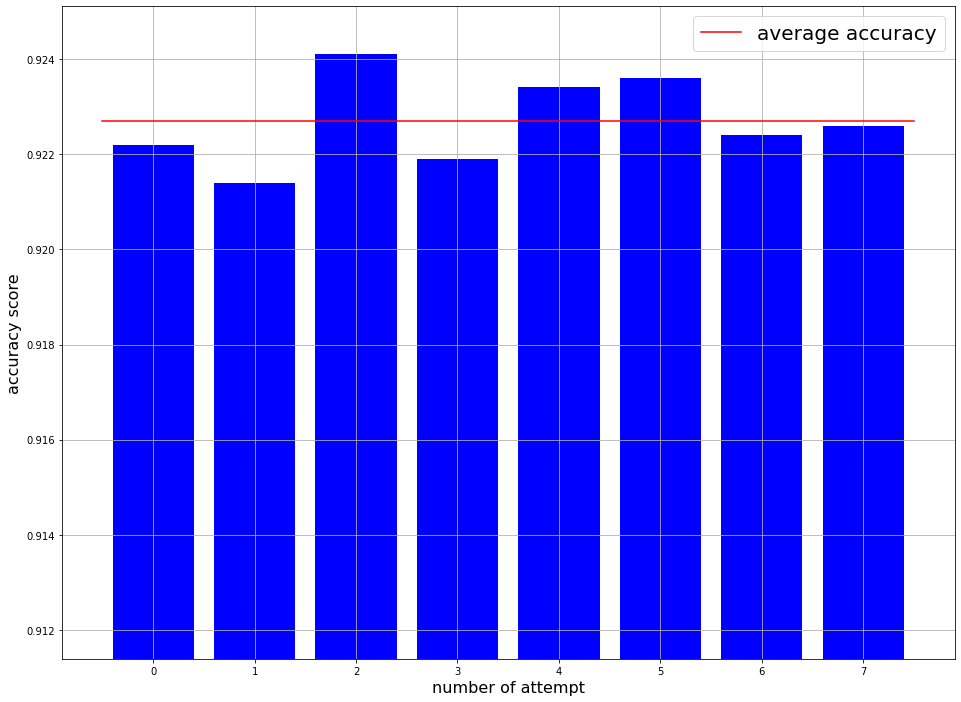

In [33]:
values = [0.9222, 0.9214, 0.9241, 0.9219, 0.9234, 0.9236, 0.9224, 0.9226]
plt.figure(figsize = (16, 12))
plt.ylim([min(values) - 0.01, max(values) + 0.001])
plt.bar(range(8), values, color='blue')
plt.plot([-0.5, 7.5], [np.average(np.array(values)), np.average(np.array(values))], color = 'red', label = 'average accuracy')
plt.grid()
plt.legend(loc = 'best', prop = {'size' : 20})
plt.xlabel('number of attempt', fontsize=16)
plt.ylabel('accuracy score', fontsize=16)
plt.show()

In [ ]:
classes = [
            '1.Alfalfa',
            '2.Corn-notill',
            '3.Corn-mintill',
            '4.Corn',
            '5.Grass-pasture',
            '6.Grass-trees',
            '7.Grass-pasture-mowed',
            '8.Hay-windrowed',
            '9.Oats',
            '10.Soybean-notill',
            '11.Soybean-mintill',
            '12.Soybean-clean',
            '13.Wheat',
            '14.Woods',
            '15.Buildings-Grass-Trees-Drives',
            '16.Stone-Steel-Towers'
]

In [ ]:
pred = np.argmax(model.predict(X_test), axis = 1)
print(classification_report(pred, np.argmax(y_test, 1),
      target_names = classes))

                                 precision    recall  f1-score   support

                      1.Alfalfa       0.79      0.92      0.85        12
                  2.Corn-notill       0.89      0.93      0.91       406
                 3.Corn-mintill       0.78      0.92      0.85       211
                         4.Corn       0.92      0.75      0.82        87
                5.Grass-pasture       0.94      0.96      0.95       142
                  6.Grass-trees       0.99      0.97      0.98       224
          7.Grass-pasture-mowed       0.75      1.00      0.86         6
                8.Hay-windrowed       0.99      0.97      0.98       146
                         9.Oats       0.67      1.00      0.80         4
              10.Soybean-notill       0.90      0.93      0.92       285
             11.Soybean-mintill       0.94      0.90      0.92       776
               12.Soybean-clean       0.97      0.91      0.94       190
                       13.Wheat       1.00      0.

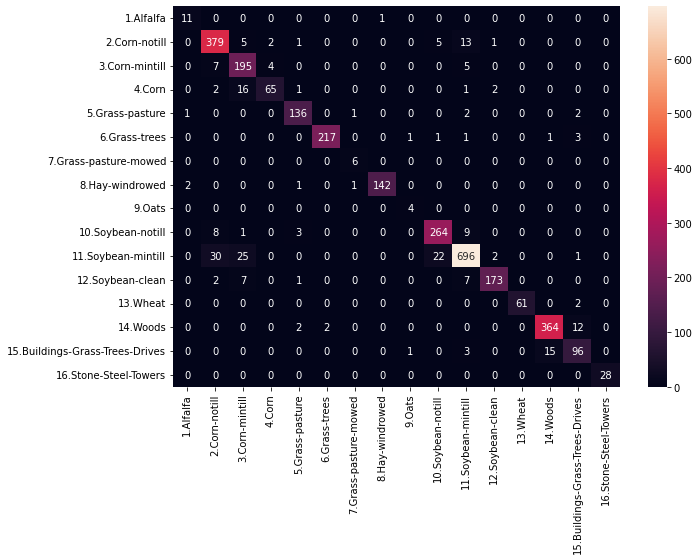

In [ ]:
plt.figure(figsize = (10,7))
mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(y_test, 1), 1))
df_cm = pd.DataFrame(mat, index = classes, columns = classes)
heatmap(df_cm, annot = True, fmt = 'd')
plt.show()